# Working with nuclide vectors

The definition of a *material card* in MCNP requires the specification of the nuclide vector either in terms of atomic or weight fractions.
The convertion from one to the other is automatically performed by MNCP and printed in output.

The fractions do not need to be normalized.
MCNP automatically performs the normalization to the density value specified for that material --- once again either in mass or atoms in a unit volume.

When it comes to the analysis and postprocessing of the MCNP inputs, running MCNP with the mere task of performing the normalization or the unit conversion of the nuclide vector is an overkill.

Below we describe ALEPH object `aleph.Composition` that solves such problem without the need of MCNP. In addition, many more interesting features were included.

In [1]:
import pytest

import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

%matplotlib notebook

In [3]:
import aleph

## What is a `aleph.Composition` object?

A `aleph` object `Composition` was developed to store the density fractions of a given material in a tabular format indexed by the nuclide ZAM identifiers.

> $ZAM  = Z \times 10000 + A \times 10 +M$, where $A$, $Z$ and $M$ are repectively the number of nucleons, the charge number and the metastate identifier.

This object provides methods to:

- convert the compositions from atomic to weight fractions, and the other way around
- renormalize the vector to a given weight or atomic density
- deplete the material composition

## Initialization

The initialization of a `aleph.Composition` instance is identical to that of `pandas.Series`. For instance, in the example below we use a dictionary --- with ZAM identifiers as keys and atomic fractions as values --- to initialize a `aleph.Composition` into variable `nd`.

In [4]:
atomic_fractions = {
    942390: 0.037047,
    942400: 0.0017512,
    942410: 0.00011674,
    310690: 8.26605E-04,
    310710: 5.48595E-04,
}
nd = aleph.Composition(atomic_fractions)
nd

INFO:  NumExpr defaulting to 4 threads.


942390   3.70470e-02
942400   1.75120e-03
942410   1.16740e-04
310690   8.26605e-04
310710   5.48595e-04
dtype: float64

The initlization process understands that the dictionary values that are passed as arguments are atomic fractions because of their positive sign.

> Atomic fractions are in at/b/cm.

If we were to pass weight fractions we should adopt the MCNP convention and use negative signs. 

In [5]:
weight_fractions = {
    942390: -365.003298,
    942400: -17.325881,
    942410: -1.159817,
    310690: -2.348167,
    310710: -1.603613,
}
aleph.Composition(weight_fractions)

942390   -3.65003e+02
942400   -1.73259e+01
942410   -1.15982e+00
310690   -2.34817e+00
310710   -1.60361e+00
dtype: float64

> Weight fractions are in g/cm3.

### But where are the data?

The actual series is contained in the source attribute `data`, in agreement with the other `aleph` classes.

In [6]:
nd.data

942390   3.70470e-02
942400   1.75120e-03
942410   1.16740e-04
310690   8.26605e-04
310710   5.48595e-04
dtype: float64

Being a `pandas.Series`, attribute `data` gives access to many data analysis and plotting methods.

<IPython.core.display.Javascript object>


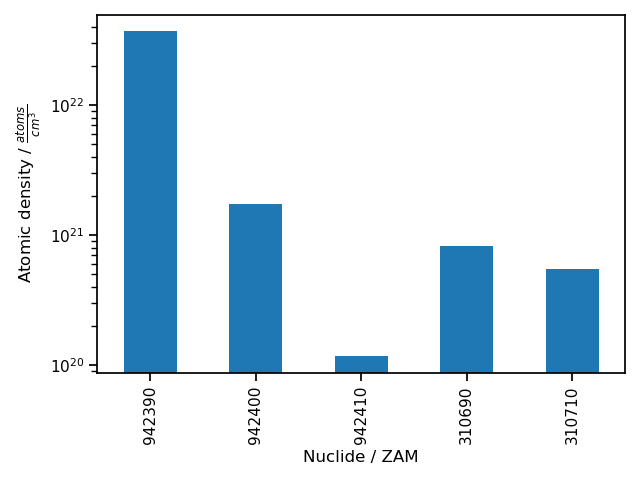

In [7]:
fig, ax = plt.subplots()
nd.data.multiply(1e24).plot(kind="bar", ax=ax, logy=True)
ax.set_xlabel("Nuclide / ZAM", fontsize="large")
ax.set_ylabel("Atomic density / $\\frac{atoms}{cm^3}$", fontsize="large")
plt.tight_layout();

## Convert from weight fractions to atomic fractions and the other way around

To translate the atomic fractions into weight fractions we can use attribute `to_weight_fractions`.

In [8]:
nd.to_weight_fractions()

942390   -1.47060e+01
942400   -6.98062e-01
942410   -4.67292e-02
310690   -9.46080e-02
310710   -6.46098e-02
dtype: float64

...and vice-versa with `to_atomic_fractions`.

In [9]:
nd.to_atomic_fractions()

942390   3.70470e-02
942400   1.75120e-03
942410   1.16740e-04
310690   8.26605e-04
310710   5.48595e-04
dtype: float64

> Nothing changed since the original data were already atomic fractions.

## Normalize fractions to a given density

The atomic and weight densities of the material can be retrieve using attributes `atomic_density` and `weight_density`.

In [10]:
nd.atomic_density
nd.weight_density

0.040290139999999995

15.610043329966283

> A material density is just the sum of the given fractions! 

Oftentimes it is useful to renormalize the material composition, for instance to 1 at/cm/b, then use method `normalize`...

In [11]:
nd.normalize(1)

942390   9.19505e-01
942400   4.34647e-02
942410   2.89748e-03
310690   2.05163e-02
310710   1.36161e-02
dtype: float64

...or to 1 g/cm3...

In [12]:
nd.normalize(-1)

942390   -9.42088e-01
942400   -4.47188e-02
942410   -2.99353e-03
310690   -6.06071e-03
310710   -4.13899e-03
dtype: float64

### Heavy metal content

For different purposes --- such as the calculation of burnup --- we are often interested in the actual content of heavy metals in the composition.
Self-explicatory method `get_heavy_metal_fraction` returns such value in g/cm3 or at/cm/b according to keyword argument `kind`.

In [13]:
nd.get_heavy_metal_fraction(kind="atomic")
nd.get_heavy_metal_fraction(kind="weight")

0.038914939999999995

15.450825576805963

> Any element with charge number $Z\geq80$ is considered a heavy metal

## Convert index from ZAM to ZA

Another reuiqrement when working with nuclide vectors is to be able to convert the ZAM identifiers into ZA identifiers that are compatible with MCNP.
Method `zam2za` was developed with this purpose.

Below we convert the ZAM identifiers of a test `aleph.Composition` object into ZA identifiers, and to make the exercise more meaningful we add some metastable isotopes in the material composition.

In [14]:
atomic_fractions = {
    952410: 0.037047,
    952420: 0.0017512,
    952421: 0.00011674,
    310690: 8.26605E-04,
    310710: 5.48595E-04,
}
aleph.Composition(atomic_fractions).zam2za()

95241   3.70470e-02
95242   1.75120e-03
95642   1.16740e-04
31069   8.26605e-04
31071   5.48595e-04
dtype: float64

> Notice that method `zam2za` returns a `pandas.Series` and not a `aleph.Composition` instance. The latter can only contain ZAM in index!

This method converts ZAM to ZA identifiers using the NNDC data convention.
According to NNDC the ZA identifier of a metastable isotope differs from the one of the isotope in the ground state according to the following rule:

* **ground state**: $ZA  = Z \times 1000 + A$, where $A$, $Z$ and $M$
* **meta state**: $ZA  = Z \times 1000 + A + 300 + M \times 100$

where $A$, $Z$ and $M$ are the number of nucleons, the charge number and the metastate identifier.

## Depletion

A depletion method was added to the `aleph.Composition` object.
Here we use it to solve the typical example of $^{210}$Po production from $^{209}$Bi activation, used to verify the depletion solver in ALEPH-2.

The nuclide vector of $^{209}$Bi is initialized as an `aleph.Composition` instance.

In [15]:
n0 = aleph.Composition({
    832090: 2.773025E-02,         # at/(b*cm)
})

Below are the decay constants, cross sections and fluxes that define the problem. 

In [16]:
bi209_activation_xs = 5.0826E-03     # barn
neutron_flux = 9.022144E+14          # n/(cm2s)
bi210g_decay_constant = 1.60066E-06  # 1/s
po210_decay_constant = 5.79714E-08   # 1/s

Let's initialize a transition matrix using `pandas` and fill it with reaction rates.

In [17]:
nuclides = [832090, 832100, 842100, 822060]

matrix = pd.DataFrame(np.zeros((4, 4)), index=nuclides, columns=nuclides)
matrix.loc[832090, 832090] = - bi209_activation_xs * 1e-24 * neutron_flux
matrix.loc[832100, 832090] = - matrix.loc[832090, 832090]
matrix.loc[832100, 832100] = - bi210g_decay_constant
matrix.loc[842100, 832100] = - matrix.loc[832100, 832100]
matrix.loc[842100, 842100] = - po210_decay_constant
matrix.loc[822060, 842100] = - matrix.loc[842100, 842100]
matrix

,832090,832100,842100,822060
832090,-4.58559e-12,0.00000e+00,0.00000e+00,0.00000e+00
832100,4.58559e-12,-1.60066e-06,0.00000e+00,0.00000e+00
842100,0.00000e+00,1.60066e-06,-5.79714e-08,0.00000e+00
822060,0.00000e+00,0.00000e+00,5.79714e-08,0.00000e+00


We are interested in the depleted composition at 5 time steps:

    - 1 day
    - 10 days
    - 100 days
    - 365 days
    - 3650 days

In [18]:
time = np.array([1, 10, 100, 365, 3650]) * 24 * 60 * 60

The depletion is simulated using method `deplete`.

In [19]:
n = n0.deplete(time, matrix, rtol=1e-10, atol=1e-15)

In [20]:
n

,86400,864000,8640000,31536000,315360000
822060,1.22417e-12,9.15683e-10,2.04934e-07,2.10281e-06,3.78023e-05
832090,2.77302e-02,2.77301e-02,2.77292e-02,2.77262e-02,2.76902e-02
832100,1.02607e-08,5.95153e-08,7.94390e-08,7.94308e-08,7.93275e-08
842100,7.24639e-10,4.94348e-08,8.14265e-07,1.82757e-06,2.19050e-06


Let's compare the output with the analytical solution.

In [21]:
analytical_solution_po210 = pd.Series([7.24639E-10,
           4.94348E-08,
           8.14265E-07,
           1.82757E-06,
           2.1905E-06], index=time)

Results are given in percent.

In [22]:
(n.T[842100] / analytical_solution_po210 - 1) * 100

86400        1.69518e-05
864000       3.72023e-05
8640000     -3.50622e-05
31536000     1.58929e-04
315360000   -4.63462e-06
dtype: float64